## Imports

In [222]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.multiclass import OneVsOneClassifier, OneVsRestClassifier
from sklearn.preprocessing import StandardScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, roc_curve
from sklearn.model_selection import train_test_split

# Original Data

In [223]:
data = pd.read_csv("./WineQT.csv", index_col="Id")
data.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
Id,,,,,,,,,,,,
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


## Data preprocessing

In [224]:
data.isnull().sum()

fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64

## **A)** Plot histogram of each attribute regarding Y=0, Y=1 and Y=2, and display the number of samples (Y) for each quality classes.
What can you say regarding the quality (Y) classes distribution?
What is your conclusion regarding the expected performance of the classifier?

The quality classes have been relabeled from numeric to categorical type using the following label encoder mapping

| Quality (Integer) | Label (Categorical) |
|:--------:|:-------:|
|   2  |  0  |
|   3  |   0  |
|   4  |   0  |
|   5   |  1  |
|   6   |  1  |
|   7   |  2   |
|   8   |  2   |

segregation of dataframe rows as per the categorical classes of the quality feature

In [225]:
class_0 = data[(data["quality"] == 2) | (data["quality"] == 3) | (data["quality"] == 4)]
class_1 = data[(data["quality"] == 5) | (data["quality"] == 6)]
class_2 = data[(data["quality"] == 7) | (data["quality"] == 8)]

quality_data = {"Poor Quality": class_0, "Medium Quality": class_1, "Premium Quality": class_2}

#### Quality-Wise feature distribution

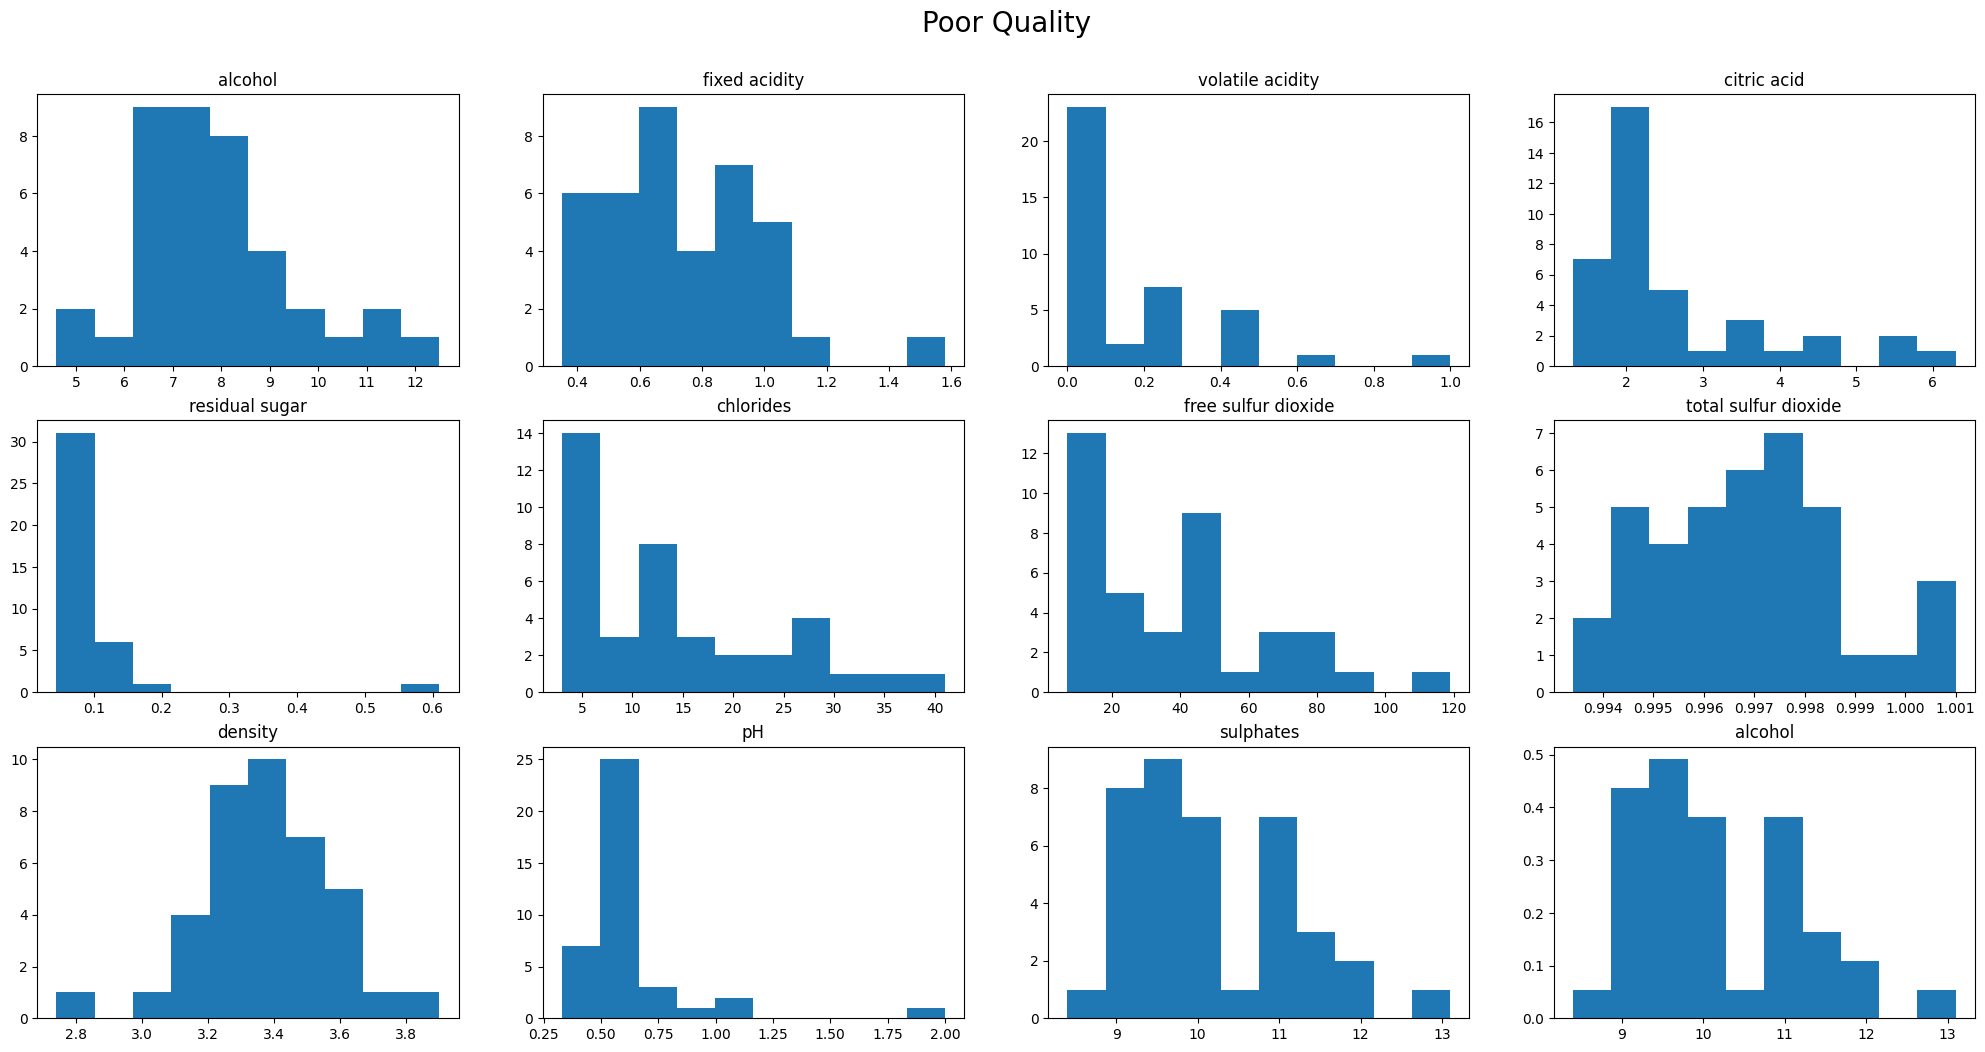

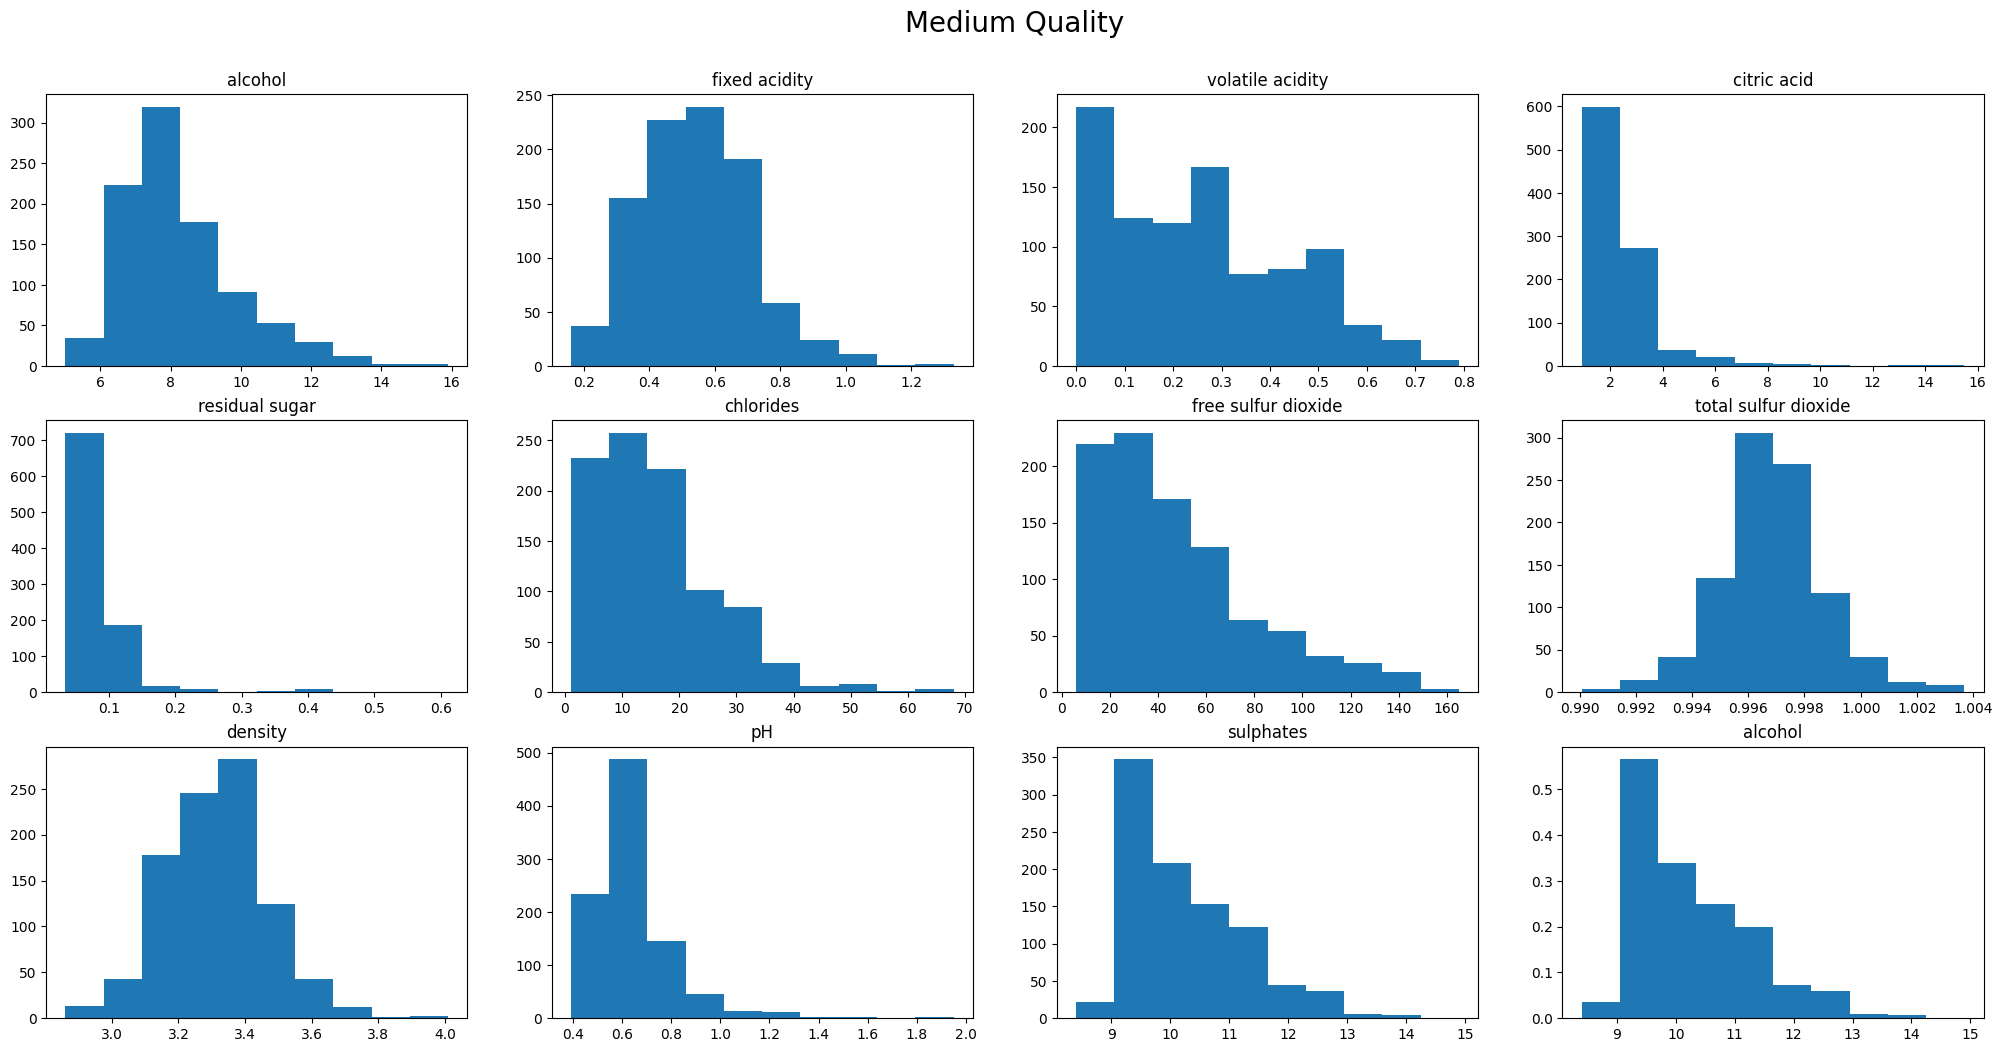

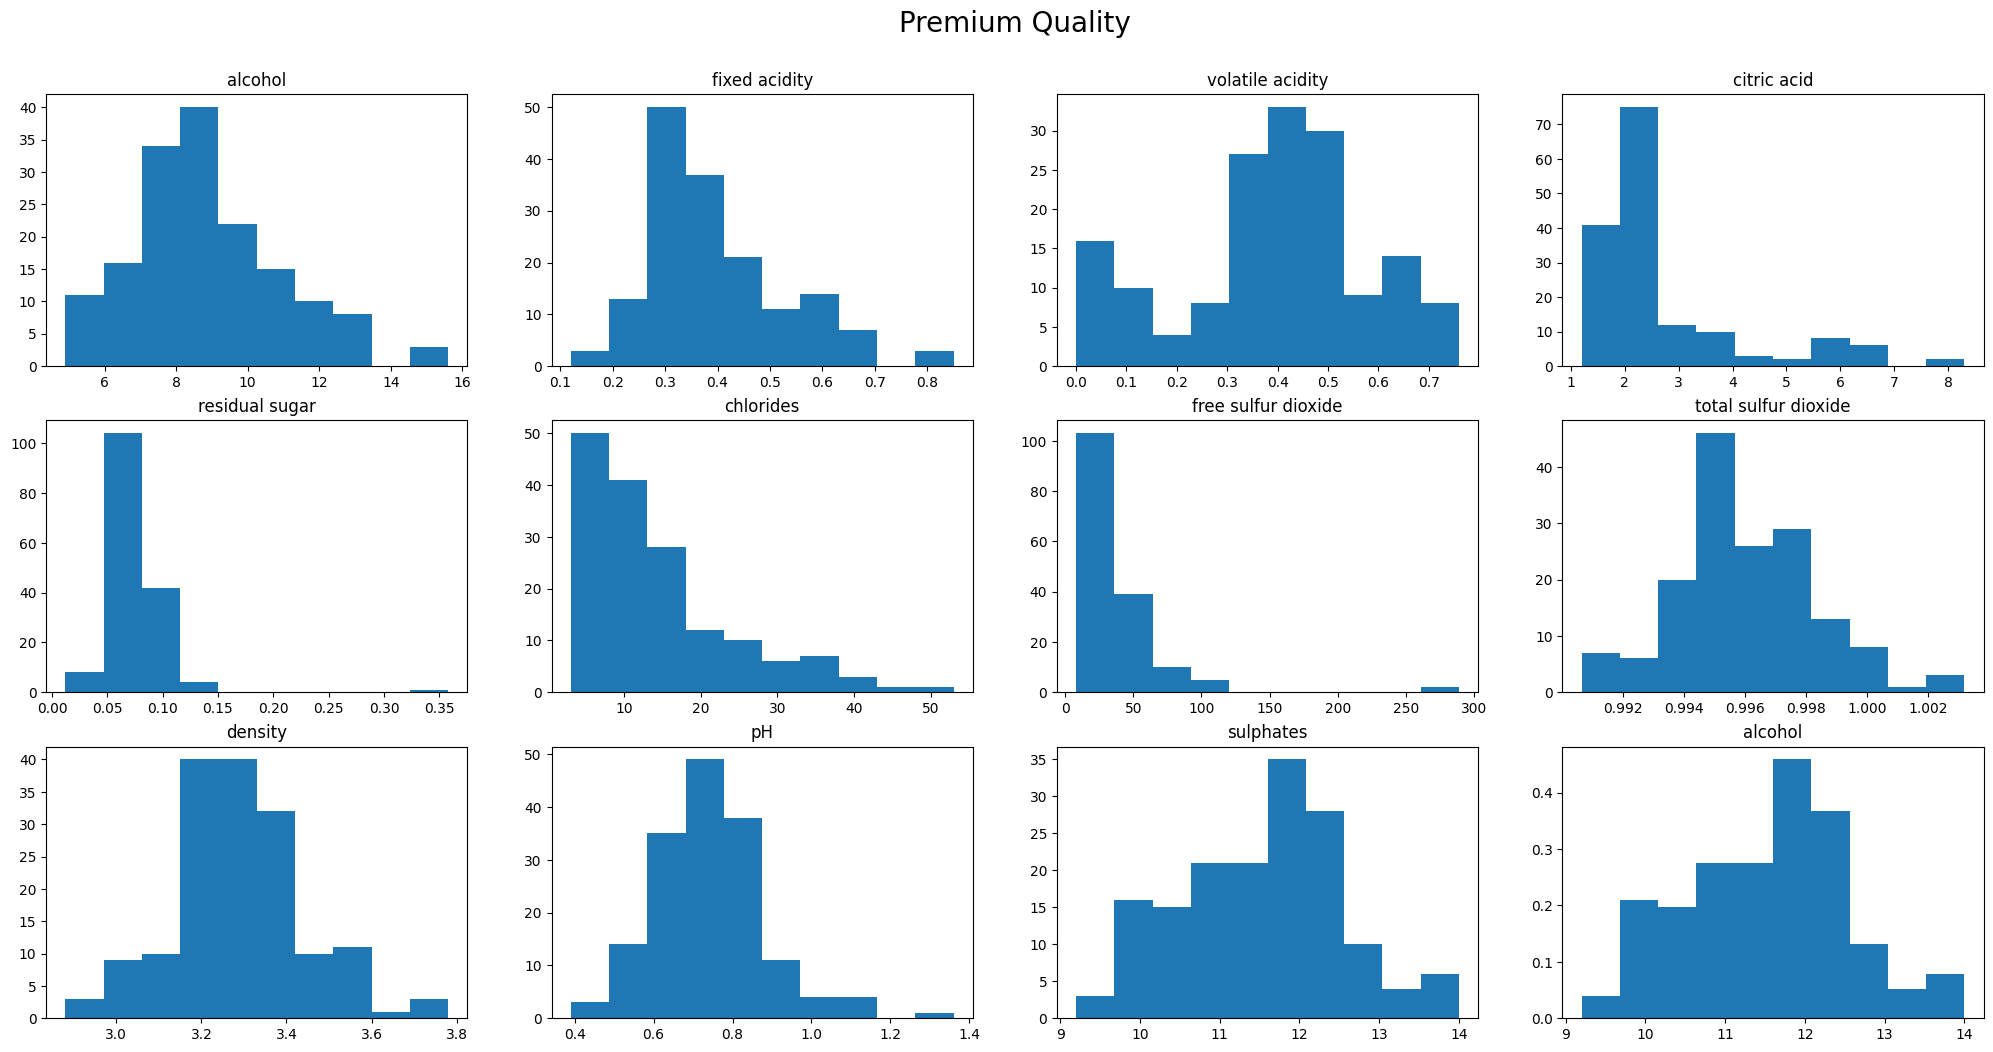

In [226]:
for quality in quality_data.keys():
    cols = quality_data[quality].columns[:-1]
    class_data = quality_data[quality]

    plt.figure(figsize=(25, 12))
    plt.title(quality, pad=45, fontdict={"size":20})
    plt.ylabel("Frequency")
    plt.axis("off")

    for i in range(4):
        for j in range(3):
            idx = (i*3) + j
            col_name = cols[idx - 1]
            if(idx + 1 == 12):
                plt.subplot(3,4,idx + 1), plt.hist(class_data[cols[idx - 1]], density=True), plt.title(col_name)
            else:
                plt.subplot(3,4,idx + 1), plt.hist(class_data[cols[idx]]), plt.title(col_name)


#### Class frequency plot

In [227]:
class_sample_distribution = {}
for key in quality_data.keys():
    class_sample_distribution[key] = len(quality_data[key])

<BarContainer object of 3 artists>

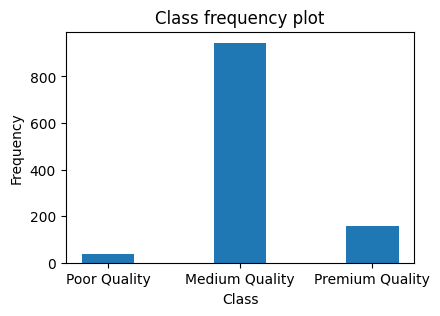

In [228]:
plt.figure(figsize=(4.5,3))
plt.title("Class frequency plot")
plt.xlabel("Class"), plt.ylabel("Frequency")
plt.bar(class_sample_distribution.keys(), class_sample_distribution.values(), width=0.4)

#### Answering Questions

**What can you say regarding the quality (Y) classes distribution?**

It is clear that the class distribution is unequally distributed. There is a large number of medium quality wine samples and a very low number of samples of the poor and premium quality wine.

**What is your conclusion regarding the expected performance of the classifier?**

Due to the biased nature of class samples, it is expected that the model will not generalize poorly on real life data. The model may have high accuracy, in this case by classifiying the majority class correctly and can even end having low classification accuracy for the poor and premium class when seen indivisually.

## **B)** Perform one run of modeling and test. Compare the obtained test accuracy by using:
1. One versus All Classifier
And
2. One versus One Classifier

#### Label Encoding

The quality classes have been relabeled from numeric to categorical type using the following label encoder mapping

| Quality (Integer) | Label (Categorical) |
|:--------:|:-------:|
|   2  |  0  |
|   3  |   0  |
|   4  |   0  |
|   5   |  1  |
|   6   |  1  |
|   7   |  2   |
|   8   |  2   |

In [229]:
map = {2: 0, 3: 0, 4: 0, 5:1, 6:1, 7:2, 8:2}
quality = data["quality"]
encoded_quality = quality.apply(lambda x: map[x])
data["Encoded_Quality"] = encoded_quality

data.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,Encoded_Quality
Id,,,,,,,,,,,,,
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,1
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5,1
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5,1
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6,1
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,1


generate dataset for train and test using stratified sampling to keep same ratios of classes in train and test

In [230]:
X, y = data[data.columns[:-2]], data[data.columns[-1]]
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=3)

In [231]:
scaler=StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.fit_transform(x_test)

#### **One VS One Classification**

In [232]:
ovo = OneVsOneClassifier(
    LogisticRegression(max_iter=500, penalty='l2')
).fit(x_train, y_train)

y_pred = ovo.predict(x_test)

**confusion matrix**

[]

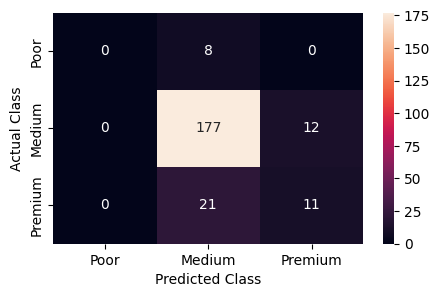

In [233]:
cf_martix_df = pd.DataFrame(confusion_matrix(y_pred=y_pred, y_true=y_test), index = ["Poor", "Medium", "Premium"],
                  columns = ["Poor", "Medium", "Premium"])
plt.figure(figsize = (5,3))
heatmap = sns.heatmap(cf_martix_df, annot=True, fmt="g")
heatmap.set_xlabel("Predicted Class")
heatmap.set_ylabel("Actual Class")
plt.plot()

here we can see that all predictions for the poor class were incorrect and more than half the predictions of premium class were also incorrect which is not desirable, even though we have a high accuracy supported majorly by the medium class due to heavy class imbalance

**classification report**

In [234]:
print(classification_report(y_pred=y_pred, y_true=y_test))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         8
           1       0.86      0.94      0.90       189
           2       0.48      0.34      0.40        32

    accuracy                           0.82       229
   macro avg       0.45      0.43      0.43       229
weighted avg       0.78      0.82      0.80       229



c:\Users\devbh\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\devbh\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\devbh\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

#### **One VS Rest Classification**

In [235]:
ovo = OneVsOneClassifier(
    LogisticRegression(penalty='l2')
).fit(x_train, y_train)

y_pred = ovo.predict(x_test)

**confusion matrix**

[]

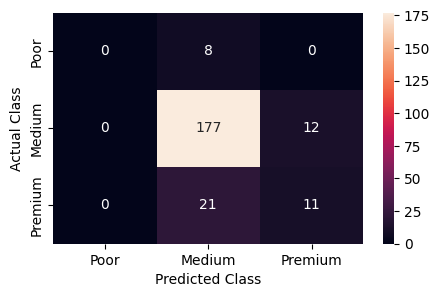

In [236]:
cf_martix_df = pd.DataFrame(confusion_matrix(y_pred=y_pred, y_true=y_test), index = ["Poor", "Medium", "Premium"],
                  columns = ["Poor", "Medium", "Premium"])
plt.figure(figsize = (5,3))
heatmap = sns.heatmap(cf_martix_df, annot=True, fmt="g")
heatmap.set_xlabel("Predicted Class")
heatmap.set_ylabel("Actual Class")
plt.plot()

here we can see that all predictions for the poor class were incorrect and more than half the predictions of premium class were also incorrect which is not desirable, even though we have a high accuracy supported majorly by the medium class due to heavy class imbalance

**classification report**

In [237]:
print(classification_report(y_pred=y_pred, y_true=y_test))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         8
           1       0.86      0.94      0.90       189
           2       0.48      0.34      0.40        32

    accuracy                           0.82       229
   macro avg       0.45      0.43      0.43       229
weighted avg       0.78      0.82      0.80       229



c:\Users\devbh\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\devbh\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\devbh\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

# New Data

In [255]:
data = pd.read_csv("./Wine_Test_02_6_8_red.csv")
data.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,8.5,0.28,0.56,1.8,0.092,35.0,103.0,0.9969,3.30,0.75,10.5,2
1,7.9,0.32,0.51,1.8,0.341,17.0,56.0,0.9969,3.04,1.08,9.2,1
2,7.6,0.39,0.31,2.3,0.082,23.0,71.0,0.9982,3.52,0.65,9.7,1
3,8.1,0.38,0.28,2.1,0.066,13.0,30.0,0.9968,3.23,0.73,9.7,2
4,7.3,0.45,0.36,5.9,0.074,12.0,87.0,0.9978,3.33,0.83,10.5,1


## Data preprocessing

In [256]:
data.isnull().sum()

fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64

## Data Visualization

segregation of dataframe rows as per the categorical classes of the quality feature

In [257]:
class_0 = data[(data["quality"] == 0)]
class_1 = data[(data["quality"] == 0)]
class_2 = data[(data["quality"] == 2)]

quality_data = {"Poor Quality": class_0, "Medium Quality": class_1, "Premium Quality": class_2}

#### Quality-Wise feature distribution

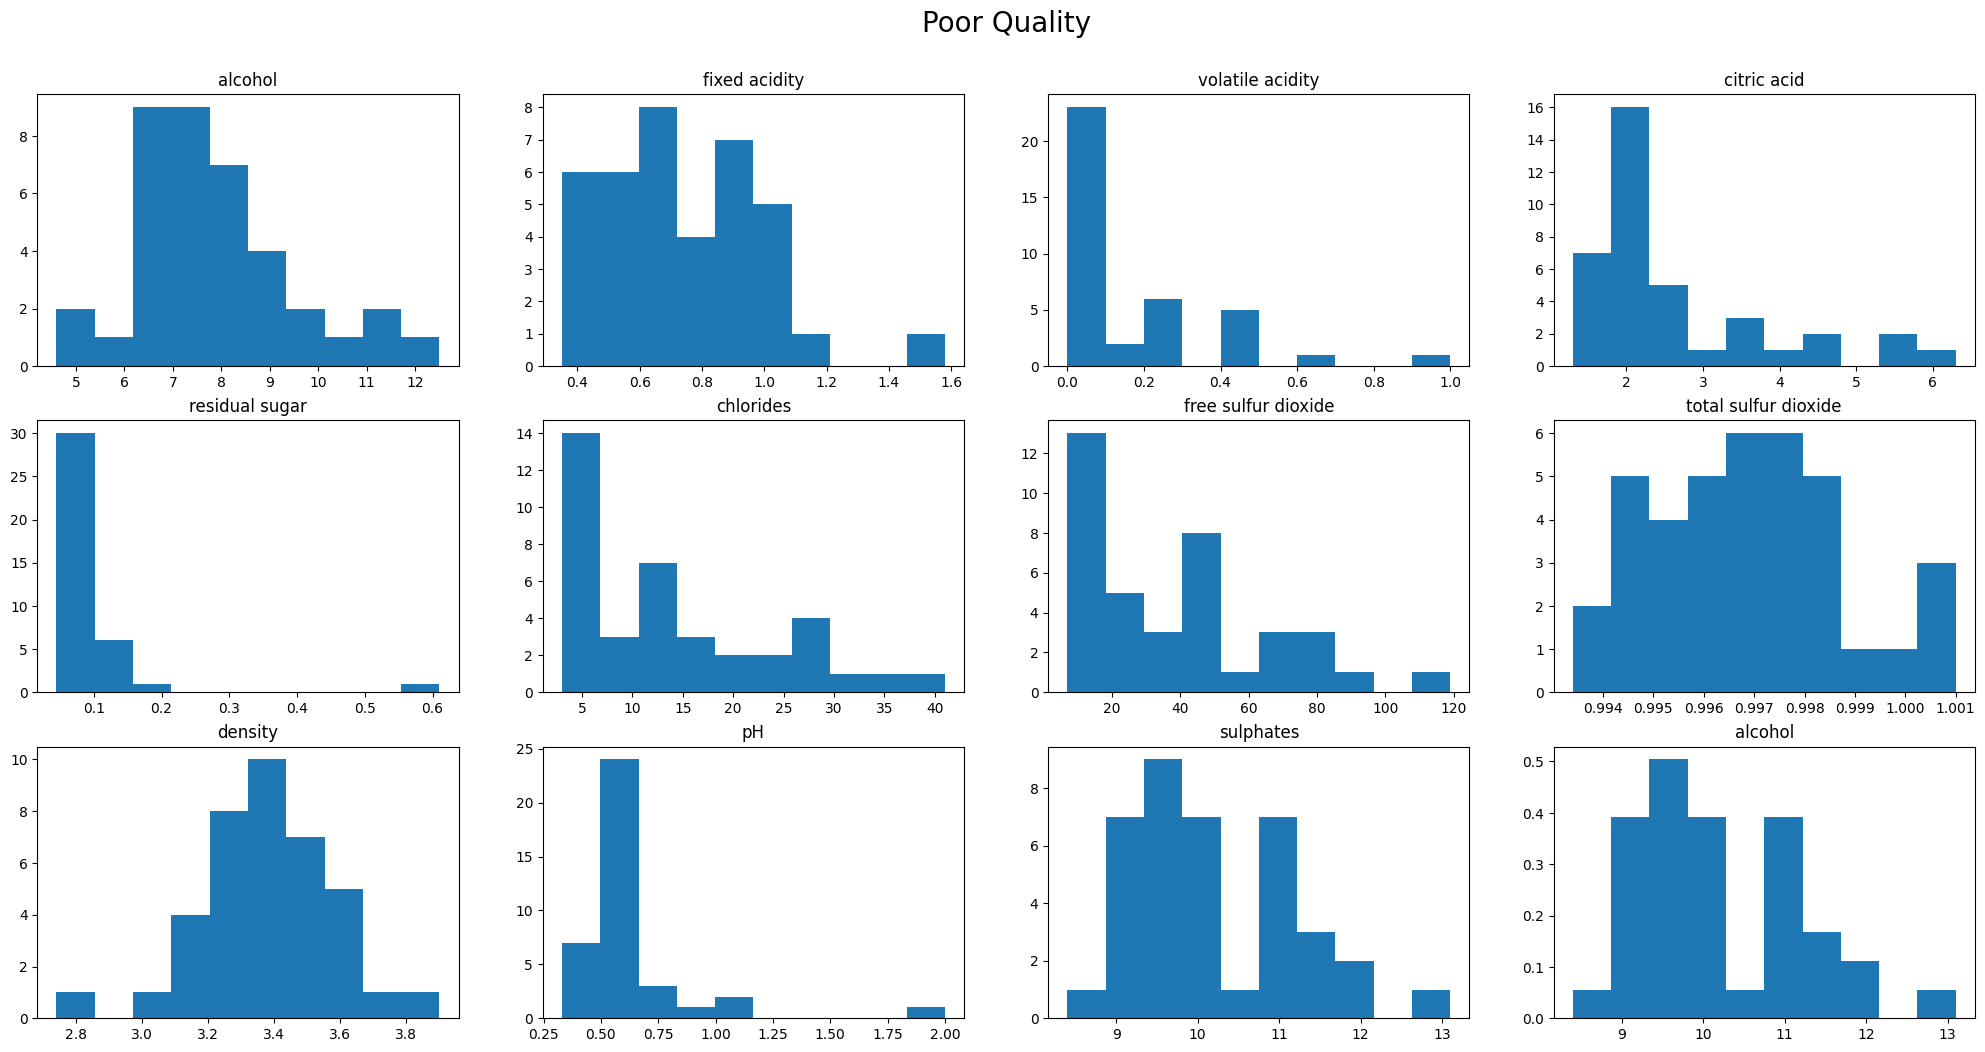

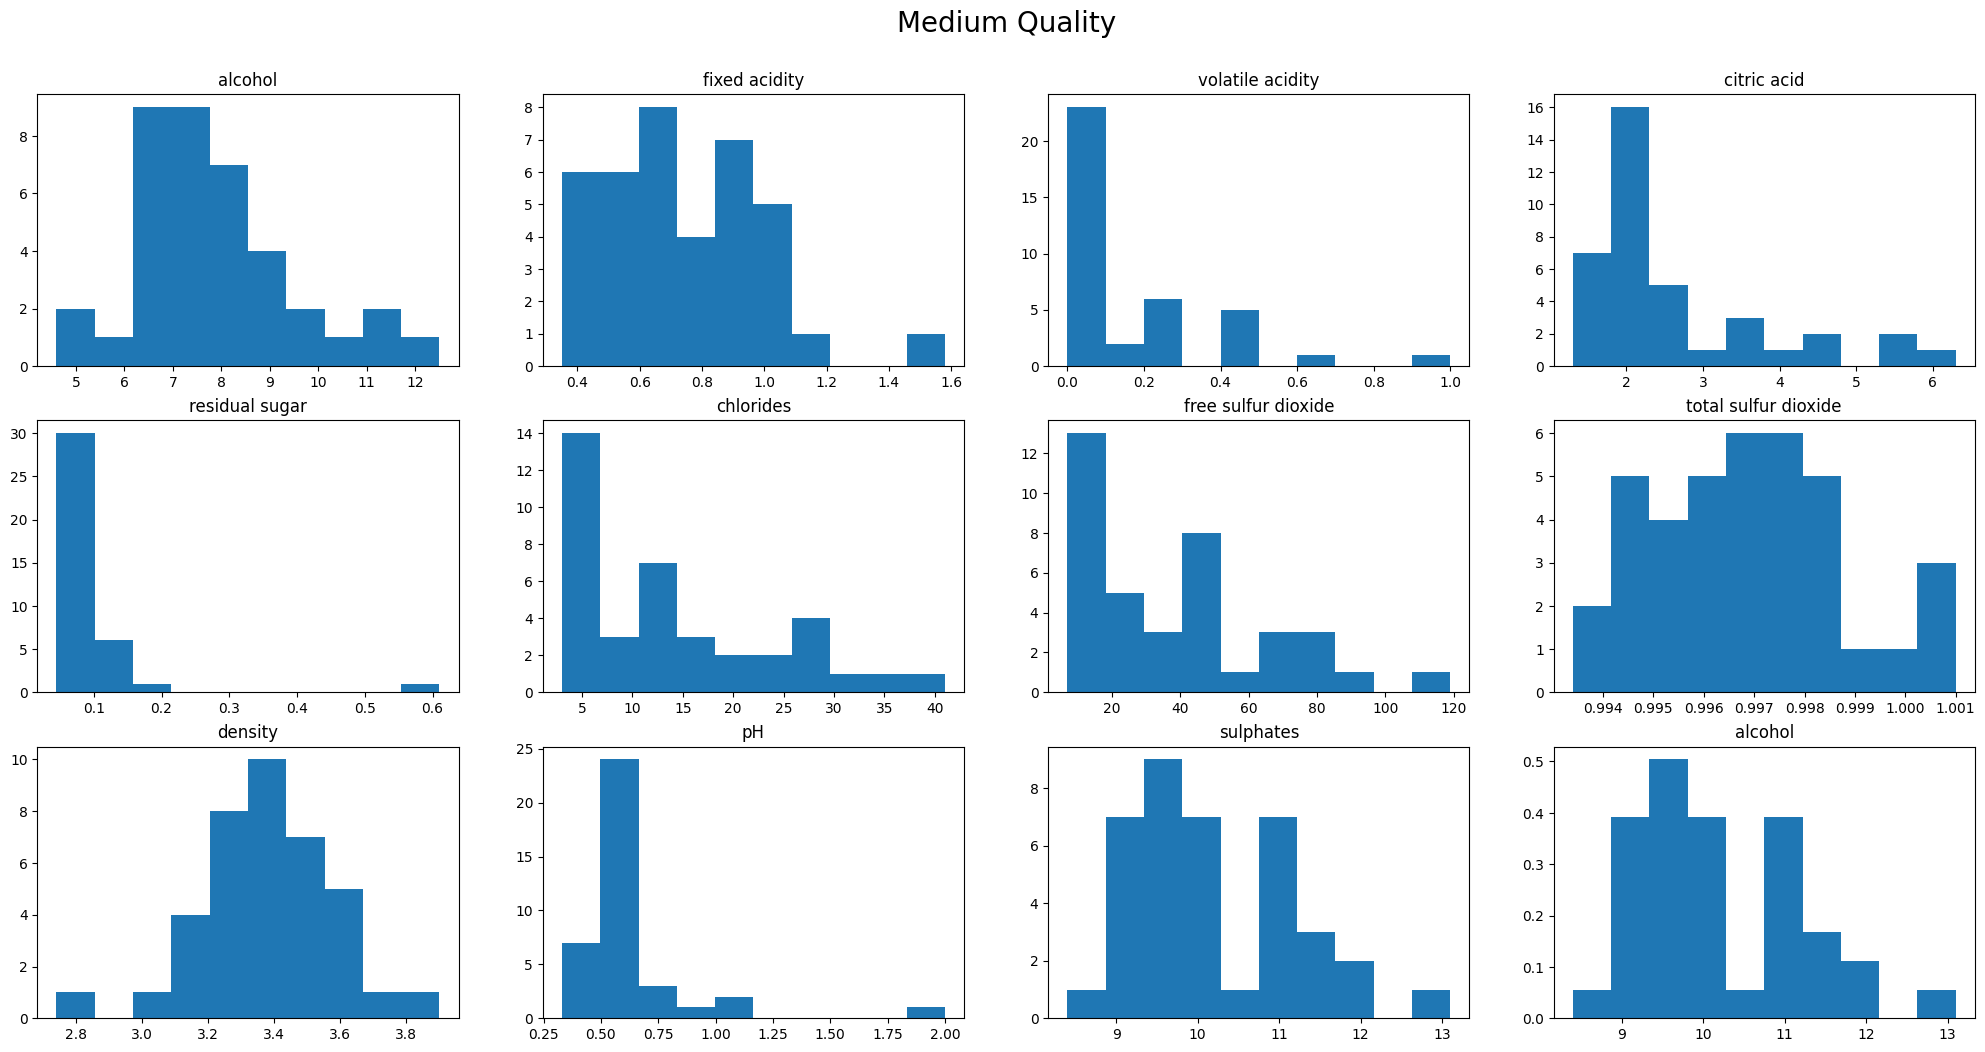

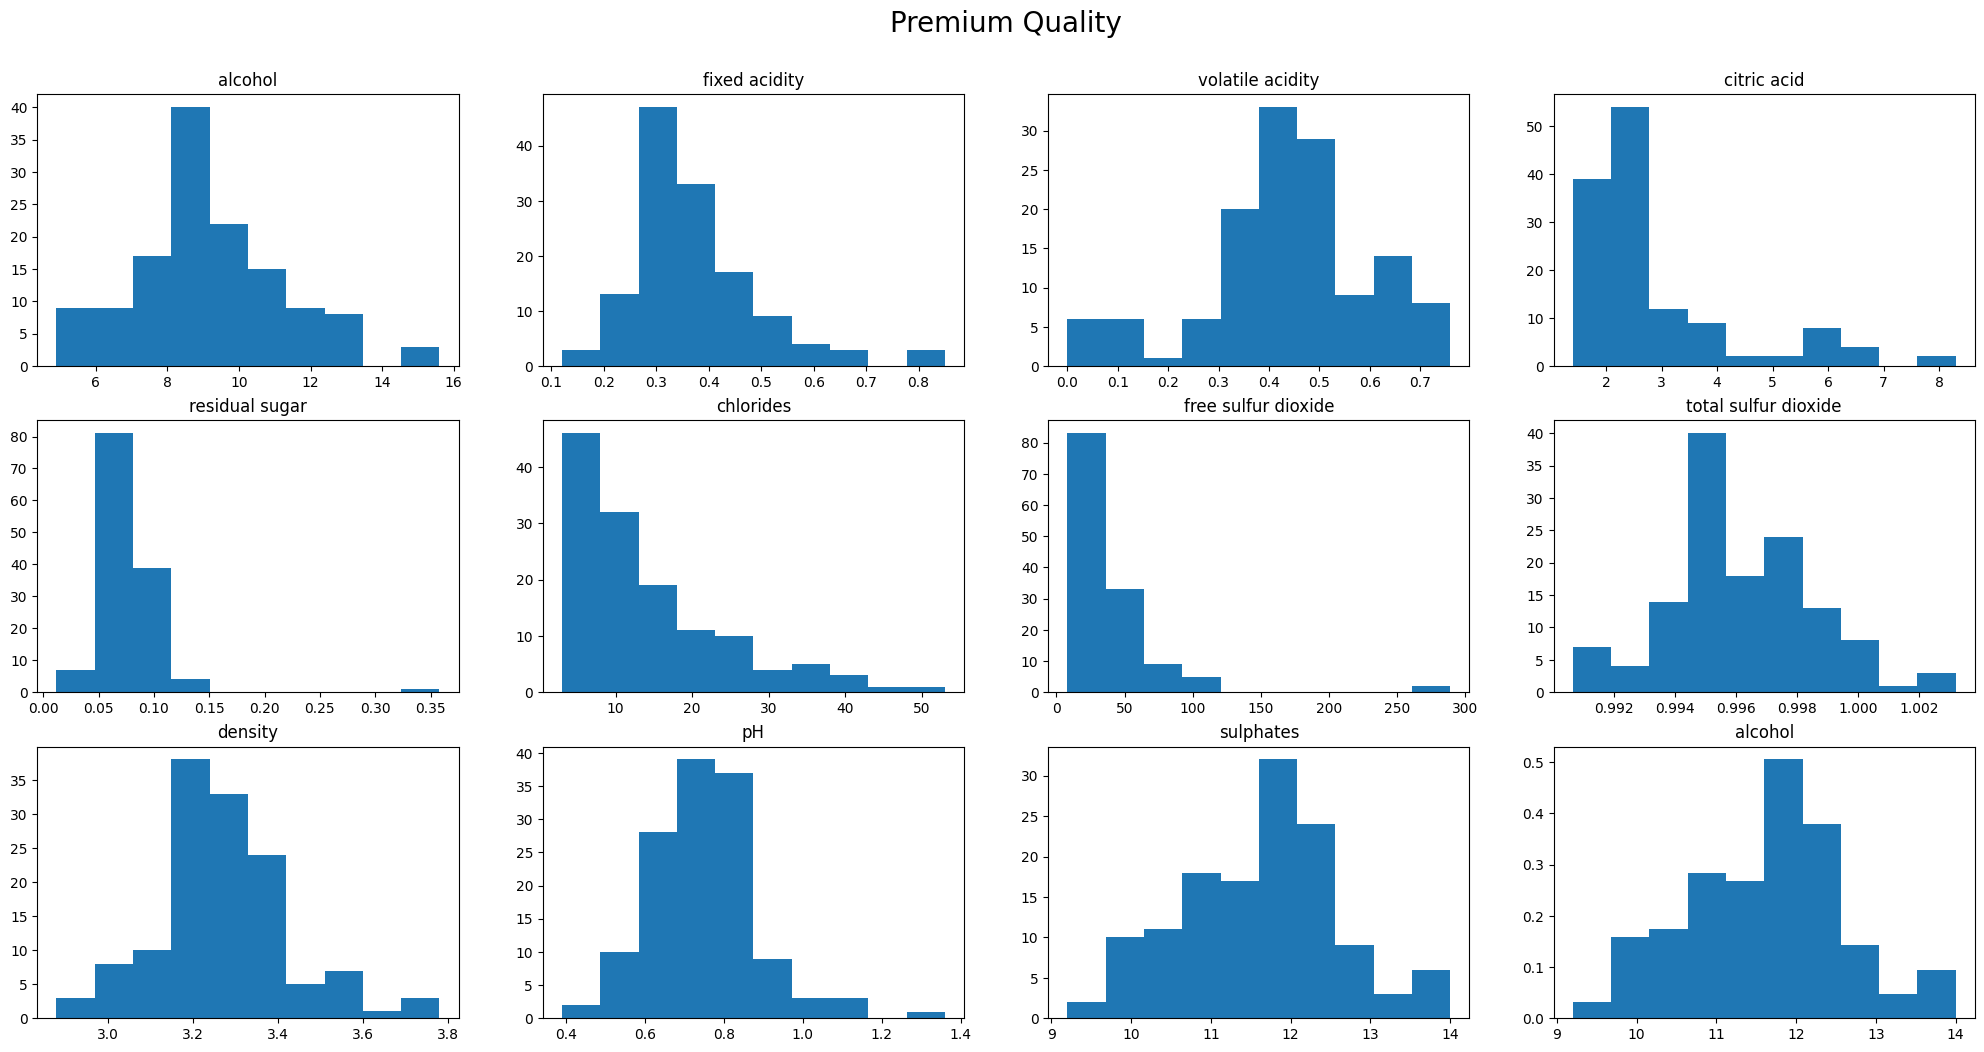

In [258]:
for quality in quality_data.keys():
    cols = quality_data[quality].columns[:-1]
    class_data = quality_data[quality]

    plt.figure(figsize=(25, 12))
    plt.title(quality, pad=45, fontdict={"size":20})
    plt.ylabel("Frequency")
    plt.axis("off")

    for i in range(4):
        for j in range(3):
            idx = (i*3) + j
            col_name = cols[idx - 1]
            if(idx + 1 == 12):
                plt.subplot(3,4,idx + 1), plt.hist(class_data[cols[idx - 1]], density=True), plt.title(col_name)
            else:
                plt.subplot(3,4,idx + 1), plt.hist(class_data[cols[idx]]), plt.title(col_name)


#### Class frequency plot

In [259]:
class_sample_distribution = {}
for key in quality_data.keys():
    class_sample_distribution[key] = len(quality_data[key])

<BarContainer object of 3 artists>

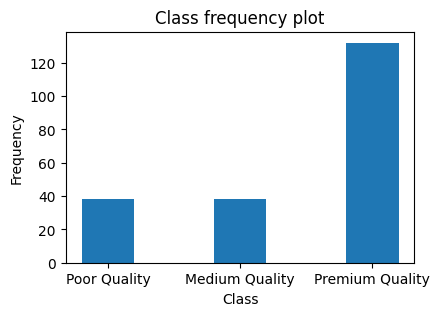

In [260]:
plt.figure(figsize=(4.5,3))
plt.title("Class frequency plot")
plt.xlabel("Class"), plt.ylabel("Frequency")
plt.bar(class_sample_distribution.keys(), class_sample_distribution.values(), width=0.4)

#### Answering Questions

**What can you say regarding the quality (Y) classes distribution?**

It is clear that the class distribution is unequally distributed. There is a large number of medium quality wine samples and a very low number of samples of the poor and premium quality wine.

**What is your conclusion regarding the expected performance of the classifier?**

Due to the biased nature of class samples, it is expected that the model will not generalize poorly on real life data. The model may have high accuracy, in this case by classifiying the majority class correctly and can even end having low classification accuracy for the poor and premium class when seen indivisually.

## **B)** Perform one run of modeling and test. Compare the obtained test accuracy by using:
1. One versus All Classifier
And
2. One versus One Classifier

generate dataset for train and test using stratified sampling to keep same ratios of classes in train and test

In [261]:
X, y = data[data.columns[:-1]], data[data.columns[-1]]
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=3)

In [262]:
scaler=StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.fit_transform(x_test)

#### **One VS One Classification**

In [263]:
ovo = OneVsOneClassifier(
    LogisticRegression(max_iter=500, penalty='l2')
).fit(x_train, y_train)

y_pred = ovo.predict(x_test)

**confusion matrix**

[]

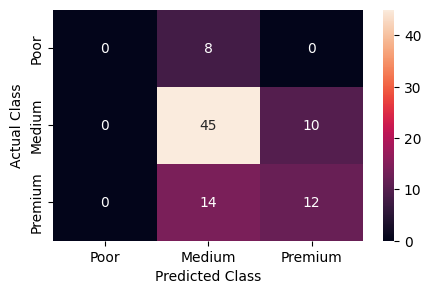

In [264]:
cf_martix_df = pd.DataFrame(confusion_matrix(y_pred=y_pred, y_true=y_test), index = ["Poor", "Medium", "Premium"],
                  columns = ["Poor", "Medium", "Premium"])
plt.figure(figsize = (5,3))
heatmap = sns.heatmap(cf_martix_df, annot=True, fmt="g")
heatmap.set_xlabel("Predicted Class")
heatmap.set_ylabel("Actual Class")
plt.plot()

here we can see that all predictions for the poor class were incorrect and more than half the predictions of premium class were also incorrect which is not desirable, even though we have a high accuracy supported majorly by the medium class due to heavy class imbalance

**classification report**

In [265]:
print(classification_report(y_pred=y_pred, y_true=y_test))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         8
           1       0.67      0.82      0.74        55
           2       0.55      0.46      0.50        26

    accuracy                           0.64        89
   macro avg       0.41      0.43      0.41        89
weighted avg       0.57      0.64      0.60        89



c:\Users\devbh\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\devbh\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\devbh\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

#### **One VS Rest Classification**

In [266]:
ovo = OneVsOneClassifier(
    LogisticRegression(penalty='l2')
).fit(x_train, y_train)

y_pred = ovo.predict(x_test)

**confusion matrix**

[]

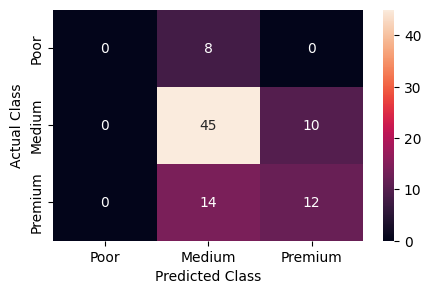

In [267]:
cf_martix_df = pd.DataFrame(confusion_matrix(y_pred=y_pred, y_true=y_test), index = ["Poor", "Medium", "Premium"],
                  columns = ["Poor", "Medium", "Premium"])
plt.figure(figsize = (5,3))
heatmap = sns.heatmap(cf_martix_df, annot=True, fmt="g")
heatmap.set_xlabel("Predicted Class")
heatmap.set_ylabel("Actual Class")
plt.plot()

here we can see that all predictions for the poor class were incorrect and more than half the predictions of premium class were also incorrect which is not desirable, even though we have a high accuracy supported majorly by the medium class due to heavy class imbalance

**classification report**

In [268]:
print(classification_report(y_pred=y_pred, y_true=y_test))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         8
           1       0.67      0.82      0.74        55
           2       0.55      0.46      0.50        26

    accuracy                           0.64        89
   macro avg       0.41      0.43      0.41        89
weighted avg       0.57      0.64      0.60        89



c:\Users\devbh\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\devbh\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\devbh\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,